In [2]:
import numpy as np
from skimage import io, filters
from skimage.color import rgb2gray
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

**1)  Convolution  and  filtering**

Find  an  image  and  make  it  grayscale  (2D)  if it isn’t already 
using whatever means you like. Also make an 11×11 square array  in which all the elements are the 
same. Perform a local averaging of the image by convolving it with the 11×11 array. In Python use 
convolve in the scipy.ndimage package. In MATLAB use imfilter; this is similar to conv2 but 
allows  clearer  statements  about  what  to  do  at  the  borders.  (There  are  other  subtle  differences 
between the two.) Try at least two different choices for what the convolution does near and beyond 
the image borders, one of which is zero-padding. Submit a “Zoomed in” image for each choice, and 
comment on whether they are doing what you expect.  
 
Suggestion: Pick an image that isn’t too large (maybe 600x600?), so that you can see the effects of the 
filtering more clearly. Or you can make a larger kernel – not 11×11, but something like 51×51, but 
be warned that this may be slow. 
Comment:  The  “Zoomed in” image should zoom in to the edge, of course, so you can see the 
difference between edge options. 
Comment: Recall that “zero padding” means filling all the “new” pixels beyond the edge with zeros. 

In [6]:
def showim(im_array, figsize = (15,9), show_hist = False):
    
    if show_hist:
        im_flattened = im_array.ravel()
        number_of_bins = (np.max(im_flattened) - np.min(im_flattened))
        
        plt.figure(figsize=figsize)
        plt.subplot(1,2,1)
        plt.imshow(im_array, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1,2,2)
        plt.hist(im_flattened, bins=number_of_bins, color='black') 
        plt.xlabel('Intensity Value')
        plt.ylabel('Frequency')
        plt.title('Image Intensity Histogram')

        plt.tight_layout()

    else:
        plt.figure(figsize=figsize)
        plt.imshow(im_array, cmap='gray')
        plt.axis('off')

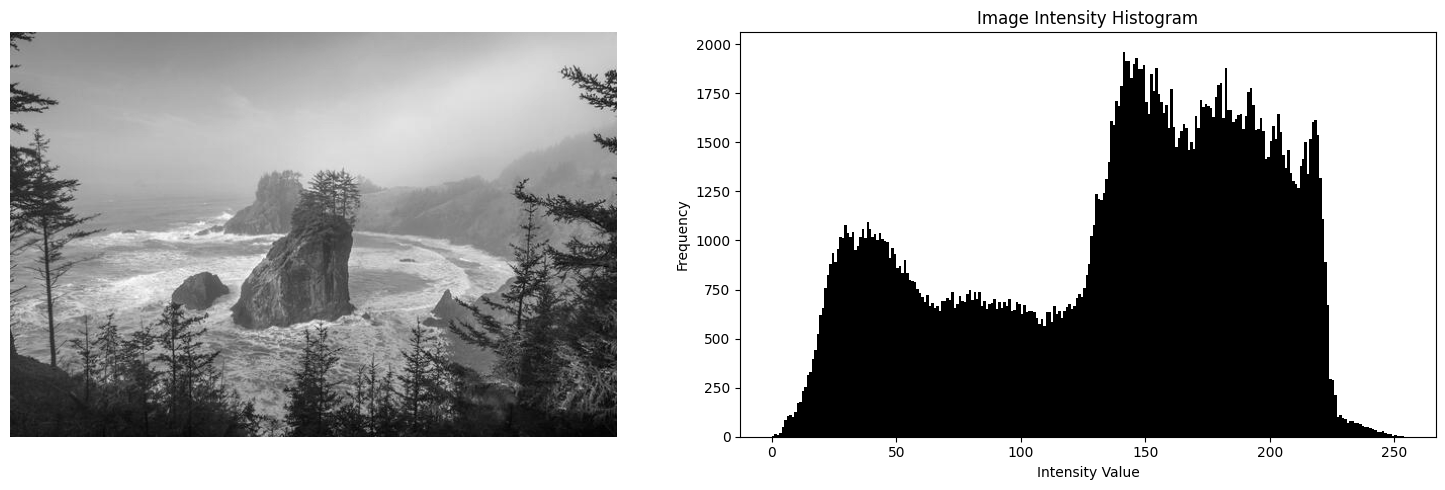

In [7]:
coast_image = (rgb2gray(io.imread('/home/apd/Projects/ImageAnalysis/HW3/Oregon-Coast-1694.jpg'))*255).astype(np.uint8)
showim(coast_image, figsize=(15,5),show_hist=True)

In [8]:
kernel_size = 11
square_kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)

conv_zero_pad = convolve(coast_image, square_kernel, mode='constant', cval=0)  
conv_reflect = convolve(coast_image, square_kernel, mode='reflect')

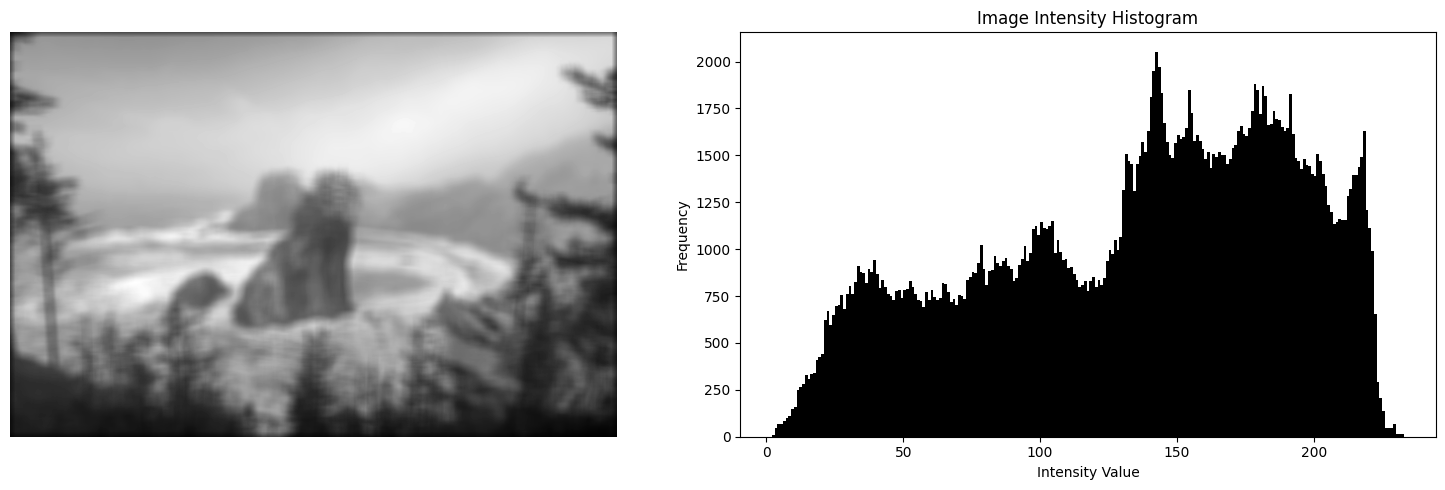

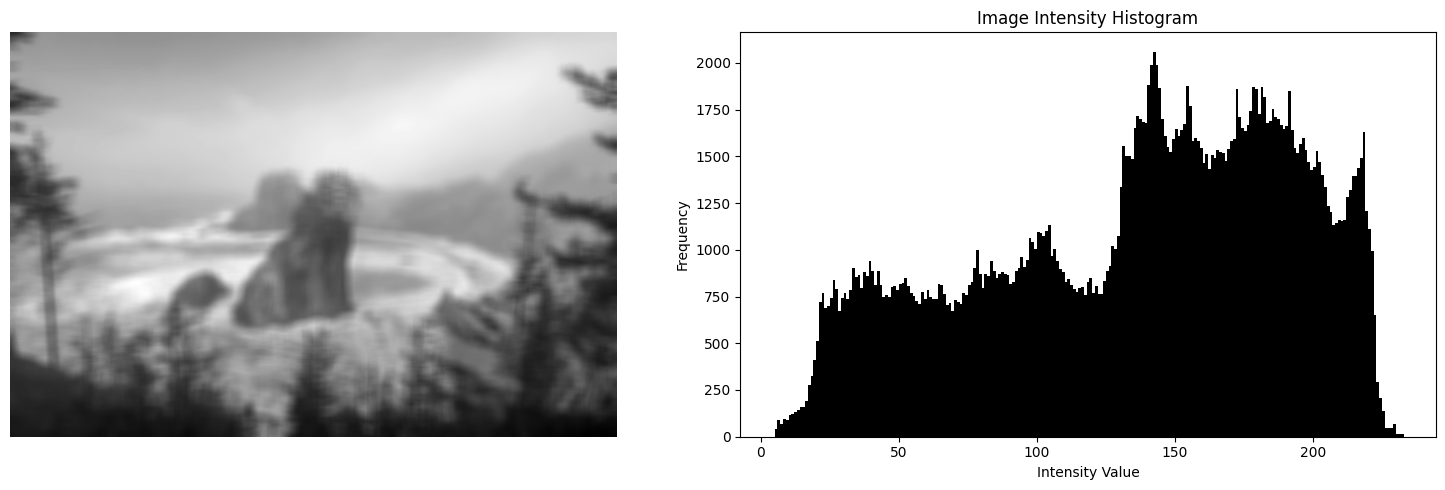

In [9]:
showim(conv_zero_pad, figsize=(15,5), show_hist=True)
showim(conv_reflect, figsize=(15,5), show_hist=True)

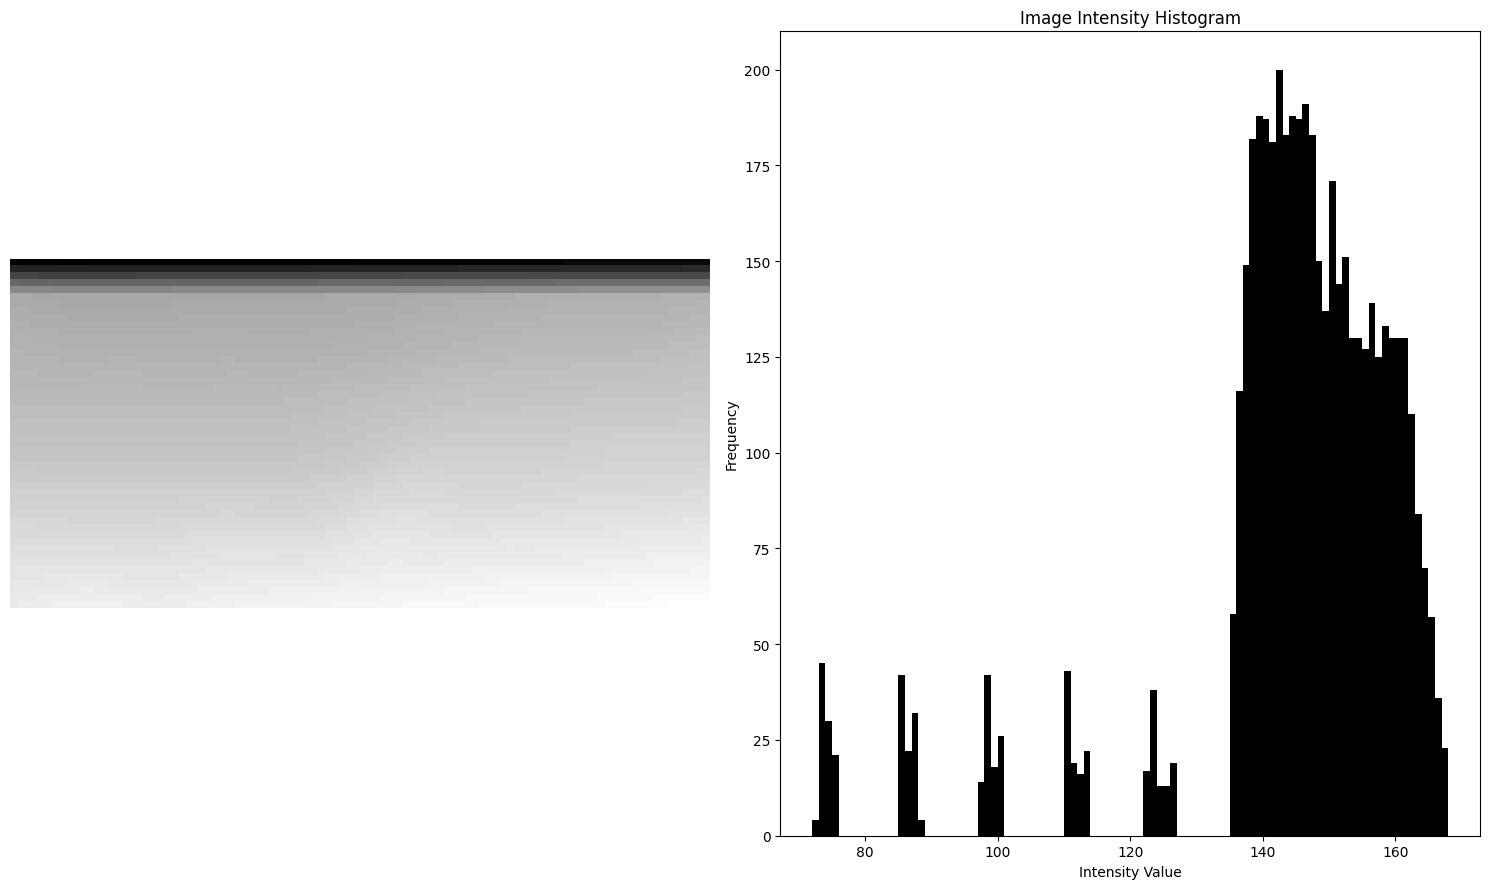

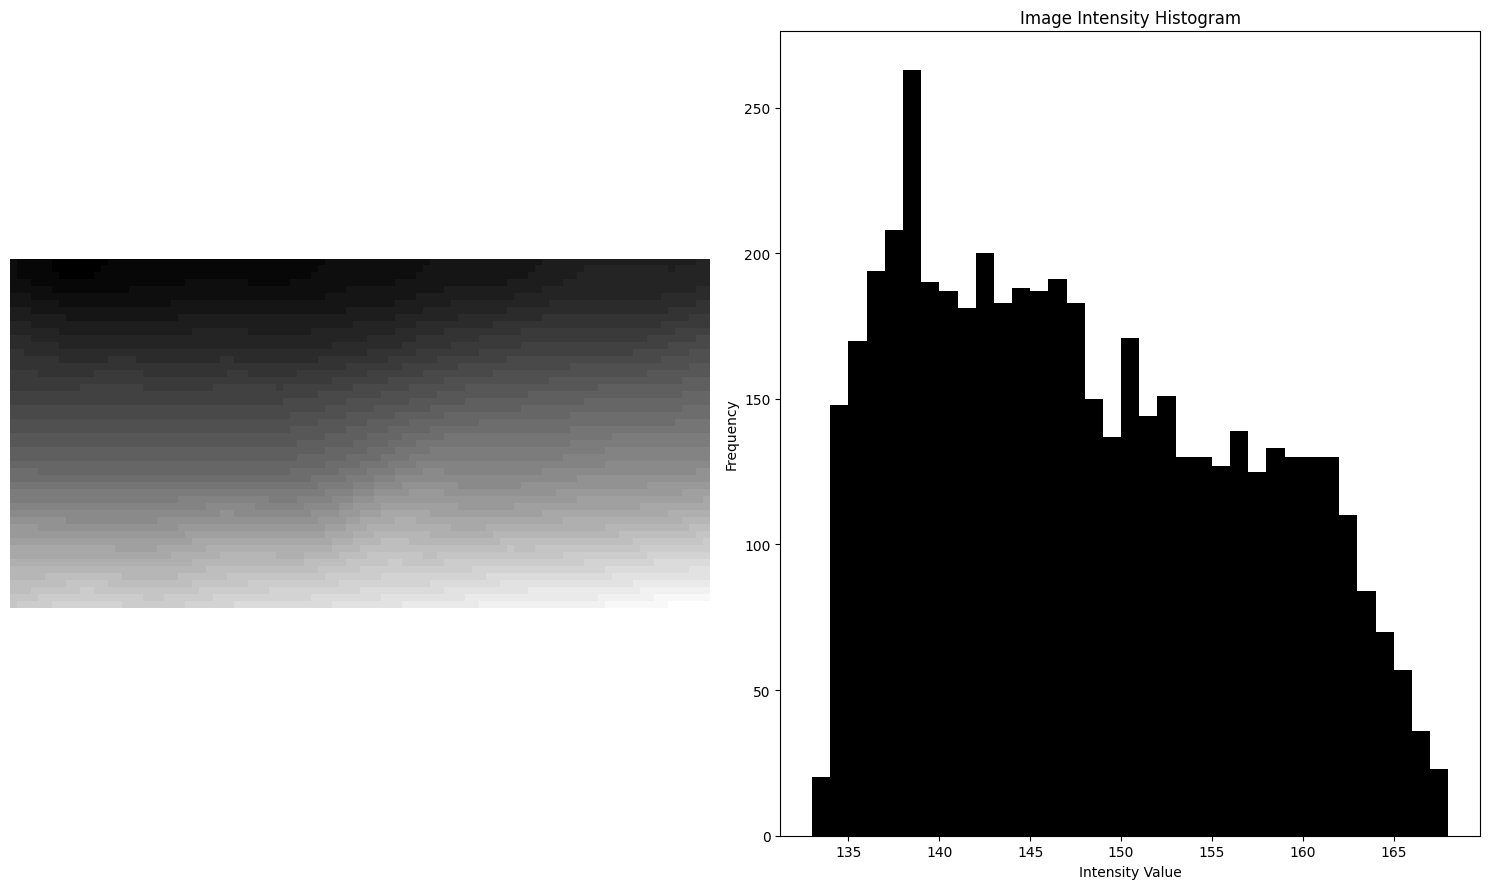

In [10]:
zoom_ROI_1 = (slice(0, 50), slice(100, 200))
zoom_1 = conv_zero_pad[zoom_ROI_1]
showim(zoom_1, show_hist=True)

zoom_ROI_2 = (slice(0, 50), slice(100, 200))
zoom_2 = conv_reflect[zoom_ROI_2]
showim(zoom_2, show_hist=True)

Both of these zooms are taken from the top left of the image, showing the top border. With zero padding, substitute values are just 0, which is apparent when looking at a histogram of the values near the border (we have discrete little peaks representing each horizontal bar as the kernel shifts upwards and more zeros need to be sibstituted in). The reflect seems to just reflect back the nearest pixel values, giving a much smoother distribution.

**2 Gaussian filtering** 

Find a grayscale image or make a color image grayscale however you 
like;  choose  an  image  that  has  some  fairly  sharp  edges.  We’ll  perform  Gaussian  filtering  of  this 
image. Note that a Gaussian function is 𝐴exp(− (𝑟^2) / 2(𝜎^2)) where r is the distance to the center.

**a)** Gaussian-filter  the  image  by  explicitly  creating  a  Gaussian  kernel  and  convolving  it 
with your image as in Problem 1. Show your code for making the kernel. (Hint: use meshgrid 
for x and y positions, then figure out “r ”.) Show the original image, an image of your kernel 
and the output of the convolution for two different values of the Gaussian width, σ. 


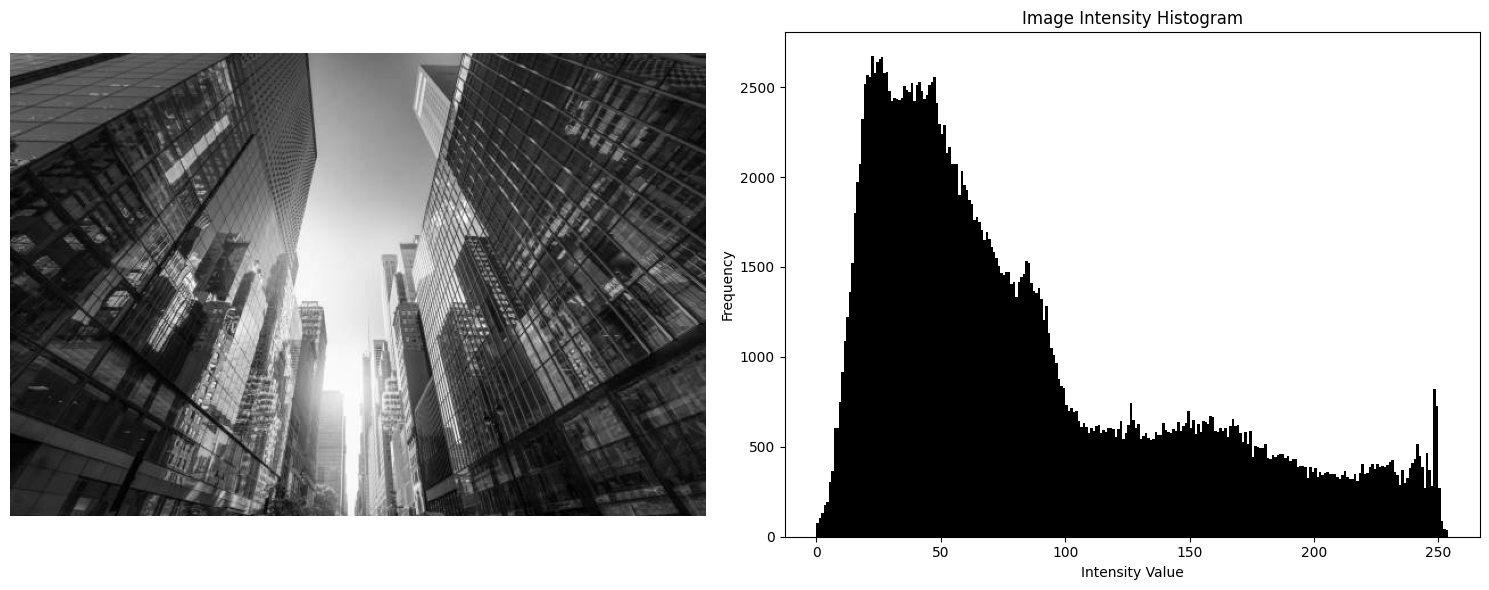

In [37]:
street_image = (rgb2gray(io.imread('/home/apd/Projects/ImageAnalysis/HW3/street2.jpg'))*255).astype(np.uint8)
showim(street_image, show_hist=True, figsize=(15,6))

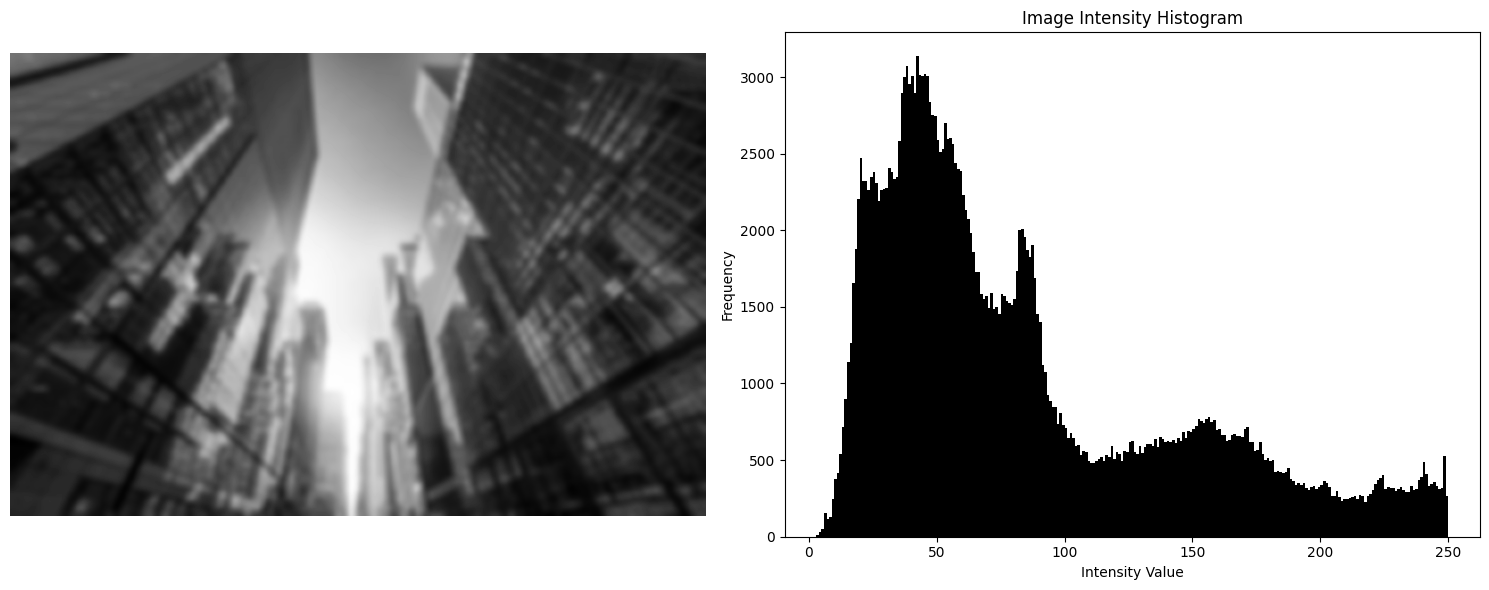

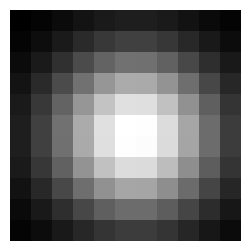

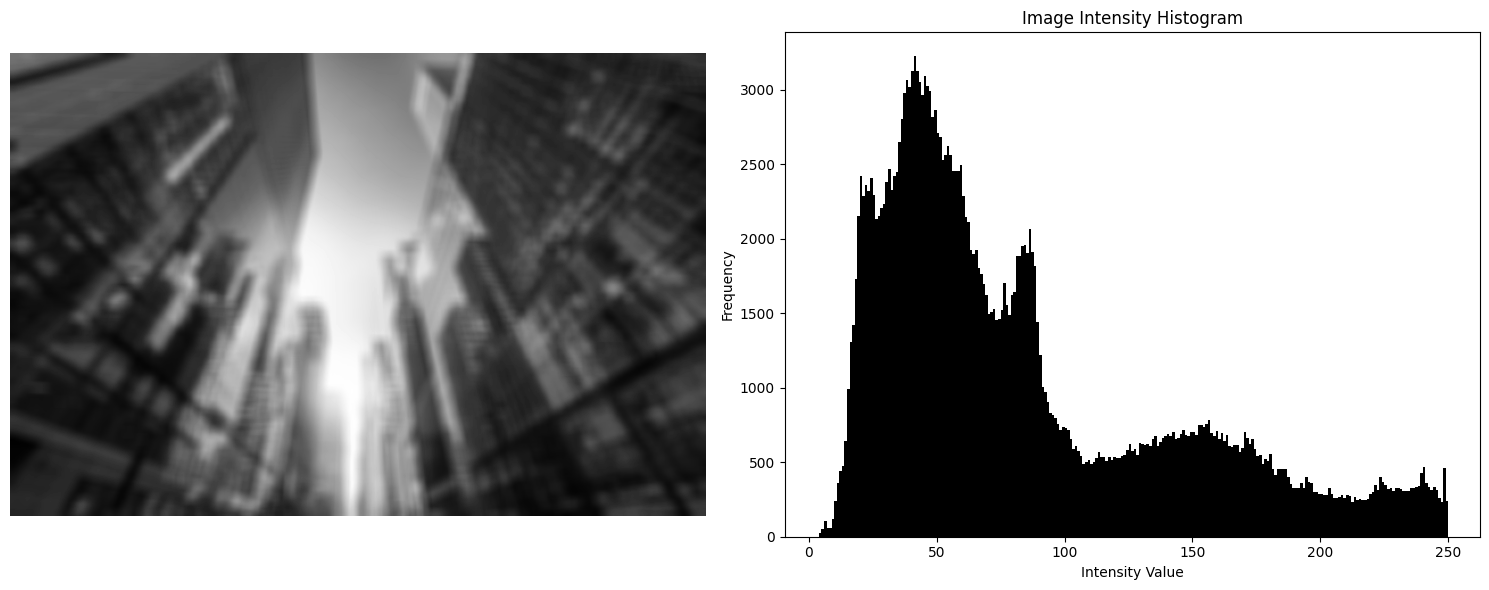

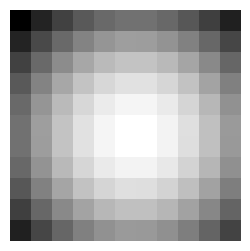

In [46]:
def create_gauss_kernel(kernel_size, sigma):
    
    length = np.linspace(-kernel_size//2, kernel_size//2, kernel_size)

    x, y = np.meshgrid(length, length)
    r = np.sqrt(x**2 + y**2)
    kernel = np.exp(-(r**2) / (2 * sigma**2))
    return kernel / kernel.sum() 

small_gauss_kernel = create_gauss_kernel(11,3)
street_conv_1 = convolve(street_image, small_gauss_kernel)
showim(street_conv_1, show_hist=True, figsize=(15,6))
showim(small_gauss_kernel, figsize=(3,3))

wider_gauss_kernel = create_gauss_kernel(11,9)
street_conv_2 = convolve(street_image, wider_gauss_kernel)
showim(street_conv_2, show_hist=True, figsize=(15,6))
showim(wider_gauss_kernel, figsize=(3,3))


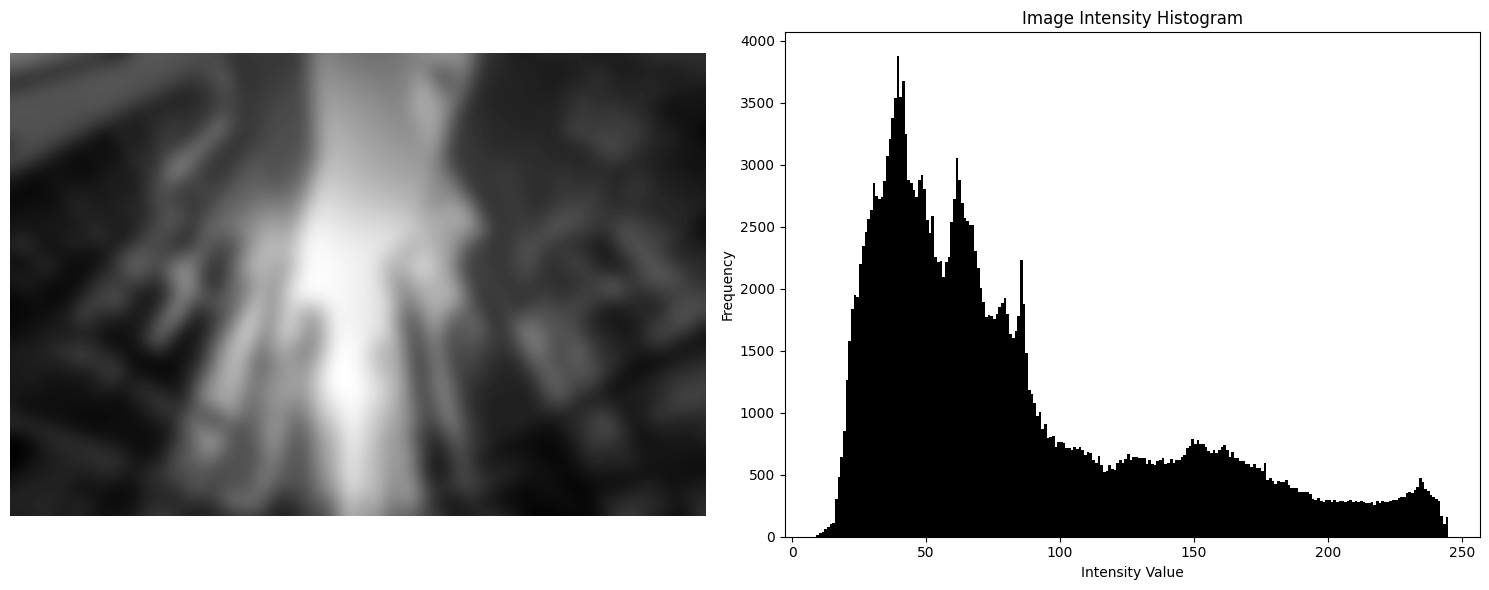

In [61]:
from skimage.filters import gaussian
new_gauss = (gaussian(street_image, sigma=9)*255).astype(np.uint8)
showim(new_gauss, show_hist=True, figsize=(15,6))

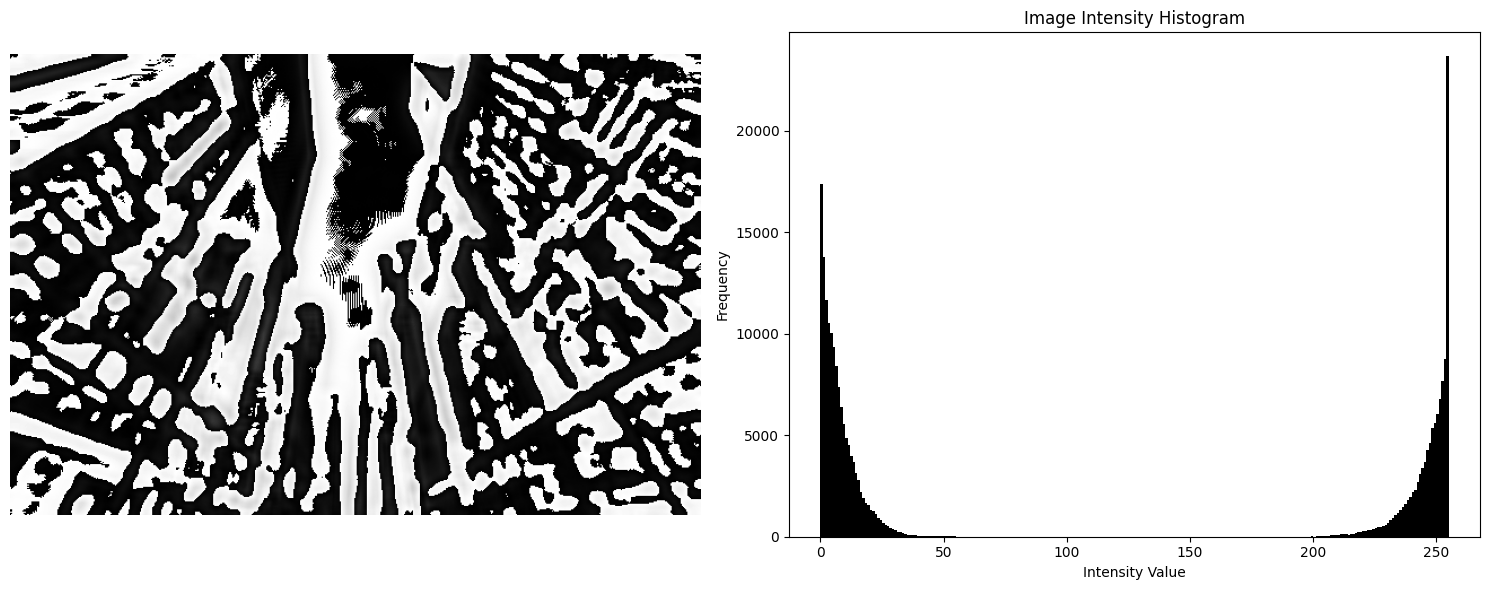

In [63]:
difference = new_gauss-street_conv_2
showim(difference, show_hist=True, figsize=(15,6))

It seems like the convolved images mainly differ around the edges of the buildings, or sharp edges. After doing some reading, it seems like skimage doesn't use an actual kernel thats an array but performs efficient mathematical operations on the image, meaning it likely doesn't have to "clip" its gaussian kernel like we do when we choose an explicit size (not sigma) for it. In that way, skimage's gaussian convolution is probably more mathematically accurate as it is able to incorporate more image information into it's calculations.

In [65]:
import time
manual_to = time.time()
manual_conv = convolve(street_image, wider_gauss_kernel)
manual_tf = time.time()

skimage_to = time.time()
skimage_conv = gaussian(street_image, sigma=9)
skimage_tf = time.time()

print(f"manual time: {manual_tf-manual_to}")
print(f"skimage time: {skimage_tf-skimage_to}")


manual time: 0.031471967697143555
skimage time: 0.012917518615722656


By decomposing a 2-D seperable kernel (matrix) into two 1-D kernels (rows), the results of the application of each of these 1-D kernels put together reconstructs the explicit application of the 2-D convolution with less computations. It scales much better with increasing kernel sizes! In the this problem, skimage likely uses this method to convolve the image, where my manual version is slower as it sticks to explicit computation off of a 2-D kernel. 